## Trabajo Práctico: Red Neuronal Lineal.

aca hay que poner una introducción supongo idk



Nota: aca en el notebook usamos algunas funciones como @, qr, de NP solo para probar y comparar con
los resultados correctos (calculados con numpy). Las soluciones a todos los sistemas verdaderos y las implementaciones de 
todas las funciones nuestras implementan cada una de estas operaciones a mano. 

Lo que si, usamos las funciones np.sum, np.min, np.max para poder vectorizar cuentas que si no tardaban mucho, 
como prodint() que se usa en nuestra multiplicacion de matrices

In [59]:
import numpy as np
import sys
import matplotlib.pyplot as plt

from alc import *
# TODO esto todo va a estar en alc cuando terminemos y hay que borrarlo
sys.path.append(".")
sys.path.append("./src")
sys.path.append("../src")
from labo00_auxiliares import *
from labo01_errores_igualdad import *
from labo02_TLs_basicas import *
from labo03_normas import *
from labo04_LU import *
from labo05_QR import *
from labo06_AVs import *
from labo07_markov import *
from labo08_SVD import *
import os


np.set_printoptions(precision=3, linewidth=150, suppress=True)

os.getcwd()[-3:]
tol = 0.01



no se explicar que hacemos las pruebas

Recordamos, los "t" son los valores de entrenamiento, y los v son los de testeo

In [58]:
#Xt, Yt, Xv, Yv = cargarDataset("cats_and_dogs") 
Xt, Yt, Xv, Yv =  cargarDatasetReducido("cats_and_dogs", 100, 100)
print(Xt.shape)
print(Xv.shape)
print(Yt[:,:3], Yt.shape)
print(Yt[:,:3], Yv.shape)

(100, 200)
(100, 200)
[[0 0 0]
 [1 1 1]] (2, 200)
[[0 0 0]
 [1 1 1]] (2, 200)


### QR
Tuvimos que cambiar la funcion de QR del labo para que acepte matrices no cuadradas.
  
Queremos no tener que volver a hacer cuentas muy largas mientras testeamos. QR por GS no es lento asi que no es tan necesario, pero lo hacemos empezando aca por consistencia

In [ ]:
cache_save_enabled = False
cache_load_enabled = False

def cache(calc, name):
    if cache_load_enabled and os.path.isfile(f"{name}.npy"):
        return np.load(f"{name}.npy")
    else:
        val = calc()
        if cache_save_enabled:
            np.save(f"{name}.npy", val)
        return val

def cache_many(calc, names):
    if cache_load_enabled and all([os.path.isfile(f"{name}.npy") for name in names]):
        return tuple([cache(lambda:None, name) for name in names])
    else:
        vals = calc()
        for name, val in zip(names, vals):
            cache(lambda:val, name)
        return vals
    
# no quiero perder horas de computo pq fallo un assert, armo esto para que si "Fallaría" el assert te avisa
def pseudoAssertEquality(X,Y, atol = tol):
    try:
        assert np.allclose(X,Y, atol=tol)
    except:
        print("ERROR: Necesita tolerancia ", np.max(np.abs(X-Y)))
    

#### Por Gram shmidt

In [40]:
tiempo = datetime.now()
Q, R = cache_many(lambda: QR_con_GS(traspuesta(Xt)), ["QGS", "RGS"])

WGS = cache(lambda:pinvGramSchmidt(Q,R,Yt), "WGS")

YvEsperadosGS = cache(lambda:matmul(WGS, Xv), "YvEsperadosGS")



<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W


In [41]:
tiempofinal = datetime.now()
print("Tardo:", (tiempofinal-tiempo).seconds, "segundos", (tiempofinal-tiempo).microseconds,"microsegundos" )

Tardo: 0 segundos 129065 microsegundos


In [ ]:

# verificamos que 
pseudoAssertEquality(Q @ R, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar

## comparemos con funcion numpy por si a caso
QNP,RNP = np.linalg.qr(traspuesta(Xt))
YvEsperadosNPQR = pinvGramSchmidt(QNP,RNP,Yt) @ Xv
pseudoAssertEquality(YvEsperadosGS,  YvEsperadosNPQR, atol=tol)




<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W


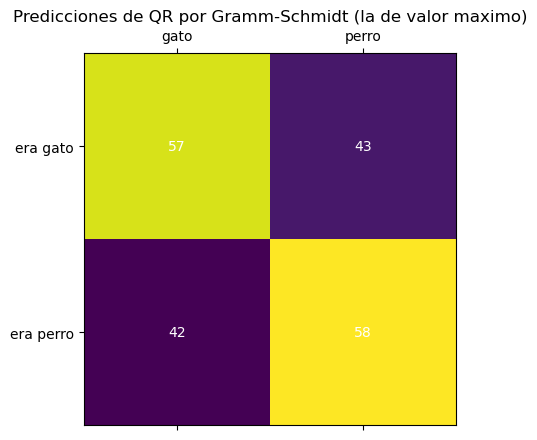

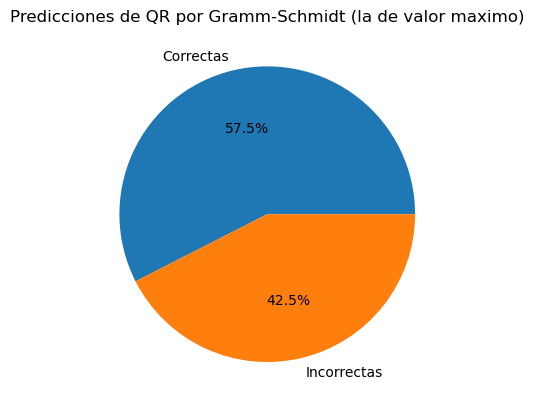

In [43]:
# medio feo tener un choclo de codigo aca pero peor era tener que importar matplotlib en ALC.py  
def graficar_predicciones_de_metodo(nombre_metodo, predicciones, valores_reales):
    gato = [1,0]
    perro = [0,1]


    posibilidadesNombres = ["gato", "perro"]
    confusion2 = np.zeros((2,2))
    for prediccion, valorCorrecto in zip(  traspuesta(predicciones) , traspuesta(valores_reales) ):
        indiceY = int(1-valorCorrecto[0])
        indiceX = int(max(prediccion) == prediccion[1])
        confusion2[ indiceY ][ indiceX ] += 1
    
    plt.matshow(confusion2)
    plt.title(f"Predicciones de {nombre_metodo} (la de valor maximo)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion2):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val < 200 else "black") 
    plt.show()
    pie(confusion2, nombre_metodo + " (la de valor maximo)")


def pie(confusion, nombre_metodo):
    correcto = 0
    incorrecto = 0
    for i in range(len(confusion)):
        correcto += confusion[i][i]

    incorrecto = len(Xv[0]) - correcto
    plt.pie([correcto, incorrecto], labels=["Correctas", "Incorrectas"], autopct='%1.1f%%')
    plt.title(f"Predicciones de {nombre_metodo}")
    plt.show()

graficar_predicciones_de_metodo("QR por Gramm-Schmidt", YvEsperadosGS, Yv)

#### Por HH

In [44]:
tiempo = datetime.now()

QHH, RHH = cache_many(lambda: QR_con_HH(traspuesta(Xt)), ["QHH", "RHH"])
WHH = cache(lambda:pinvHouseHolder(QHH,RHH,Yt), "WHH")
YvEsperadosHH = cache(lambda:matmul(WHH, Xv), "YvEsperadosHH")


householderizando 0-esima sumbatriz de 100 a las 12:55:55.898628
householderizando 10-esima sumbatriz de 100 a las 12:55:59.168592
householderizando 20-esima sumbatriz de 100 a las 12:56:02.366382
householderizando 30-esima sumbatriz de 100 a las 12:56:05.424200
householderizando 40-esima sumbatriz de 100 a las 12:56:08.394434
householderizando 50-esima sumbatriz de 100 a las 12:56:11.239251
householderizando 60-esima sumbatriz de 100 a las 12:56:13.994206
householderizando 70-esima sumbatriz de 100 a las 12:56:16.672420
householderizando 80-esima sumbatriz de 100 a las 12:56:19.298490
householderizando 90-esima sumbatriz de 100 a las 12:56:21.819186
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
listo resolviendo sistema
listo trasponiendo
Calculando W


In [45]:
print("Tardo:", (datetime.now()-tiempo).seconds, "segundos")

Tardo: 28 segundos


In [ ]:

pseudoAssertEquality(WHH, WGS, atol=tol)

pseudoAssertEquality(QHH @ RHH, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar mas rapido
print(f"W: {np.round(WHH,3).shape}")
print(YvEsperadosHH)
print(Yv)
pseudoAssertEquality(YvEsperadosHH, YvEsperadosGS, atol=tol)





W: (2, 100)
[[ 0.403 -0.173  0.172  0.977  0.011  0.317  0.913  1.095 -0.328  0.269  0.658  0.519  0.924  0.505  1.024  0.472  1.807  0.107  1.208  0.31  -0.22
   0.326 -0.059  0.807  1.276 -0.133  0.444  0.607  0.426  0.044  0.419 -0.038  0.671  0.599  0.092  0.017  0.15  -0.656  0.983 -0.295  0.509  0.712
  -0.011 -0.09   0.994  0.637  0.18   0.639  0.137  0.202  0.608  0.306  0.19   0.711 -0.27  -0.511  1.254 -0.483  0.47   0.223  1.039  1.114 -0.613
   0.618  0.434  0.86  -0.124  0.547 -0.106  0.116  0.771  0.35   0.404  0.315  0.436  2.349 -0.061 -0.52   0.681  0.568 -0.115  0.394  0.166 -0.065
  -0.392  0.721  0.348  1.408  0.045  0.704  0.636  0.385  0.505  0.02   0.623  1.178 -0.137 -0.005  0.131  0.18   0.509  1.28   0.855  0.287  1.131
  -0.012  0.144  0.211  1.094 -0.23   0.344 -0.191  0.351 -0.466  1.239  1.061 -0.257  0.85   0.55   1.63  -0.071  0.44   0.783  0.538  0.92   0.548
   0.063 -0.201  0.074  0.58   0.765  0.263  0.885  1.378  1.161  0.935 -0.324 -0.163  0.44   0

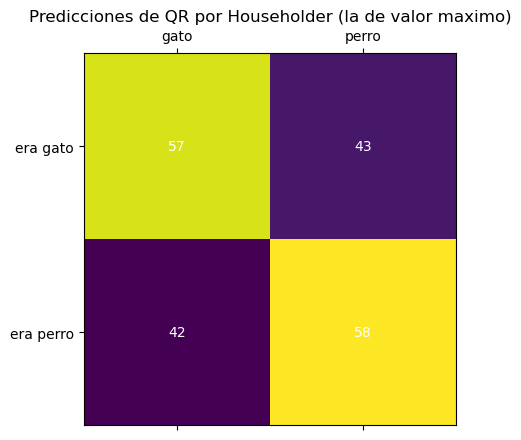

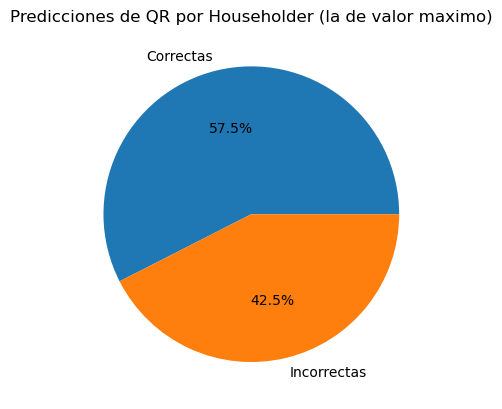

In [47]:
graficar_predicciones_de_metodo("QR por Householder", YvEsperadosHH, Yv)


### SVD

In [48]:
tiempo = datetime.now()

U,S,V = cache_many(lambda: svd_reducida(Xt, tol=tol), ["U","S","V"])

# svd_reducida, como pide su enunciado, devuelve un vector en S. pero pinvSVD tiene que tomar una matriz. 
# generamos la matriz SM
def diagFrom(list, shape):
    res = np.zeros(shape)
    for i,item in  enumerate(list):
        res[i][i] = item
    return res

 

WSVD = cache(lambda:pinvSVD(U,diagFrom(S, Xt.shape),V,Yt), "WSVD")

YvEsperadosSVD = cache(lambda:matmul(WSVD, Xv), "YvEsperadosSVD")



diagonalizando 100-esima sumbatriz a las 12:56:24.560055
diagonalizando 80-esima sumbatriz a las 12:56:26.282450
diagonalizando 60-esima sumbatriz a las 12:56:27.341308
diagonalizando 40-esima sumbatriz a las 12:56:27.900050
diagonalizando 20-esima sumbatriz a las 12:56:28.114375
listo diagonalizando 20-esima sumbatriz a las 12:56:28.161910
listo diagonalizando 40-esima sumbatriz a las 12:56:28.224646
listo diagonalizando 60-esima sumbatriz a las 12:56:28.392418
listo diagonalizando 80-esima sumbatriz a las 12:56:28.719673
listo diagonalizando 100-esima sumbatriz a las 12:56:29.257846


In [49]:
print("Tardo:", (datetime.now()-tiempo).seconds, "segundos")

Tardo: 4 segundos


In [50]:


print(f"W: {np.round(WSVD,3).shape}")
pseudoAssertEquality(U @ np.diag(S) @ traspuesta(V), Xt, atol=tol)

print(YvEsperadosSVD)
print(Yv)

# Generamos un SVD usando numpy para comparar que tan diferente queda comparada con la nuestra 
UNP,SNP,VNP = np.linalg.svd(Xt)
VNP = VNP.T[:,:Xt.shape[0]]
pseudoAssertEquality(UNP @ np.diag(SNP) @ traspuesta(VNP), Xt, atol=tol)

WSVDNP = pinvSVD(UNP,diagFrom(SNP, Xt.shape),VNP,Yt)
YvEsperadosSVDNP = WSVDNP @ Xv

pseudoAssertEquality(YvEsperadosSVD, YvEsperadosSVDNP, atol=tol)


W: (2, 100)
[[ 0.383 -0.156  0.2    0.984  0.008  0.348  0.894  1.063 -0.366  0.286  0.704  0.532  0.981  0.486  1.055  0.439  1.777  0.135  1.233  0.238 -0.204
   0.34  -0.073  0.834  1.279 -0.115  0.456  0.563  0.439  0.128  0.38  -0.104  0.707  0.611  0.115 -0.039  0.097 -0.632  0.942 -0.343  0.501  0.755
  -0.057 -0.09   1.025  0.613  0.193  0.608  0.132  0.264  0.644  0.309  0.207  0.67  -0.271 -0.574  1.263 -0.513  0.411  0.273  1.063  1.094 -0.617
   0.526  0.445  0.871 -0.127  0.558 -0.098  0.108  0.784  0.354  0.424  0.326  0.437  2.383 -0.071 -0.551  0.703  0.535 -0.097  0.352  0.185 -0.076
  -0.393  0.746  0.378  1.448  0.049  0.673  0.594  0.432  0.52   0.039  0.579  1.162 -0.152 -0.038  0.103  0.157  0.462  1.258  0.871  0.309  1.112
  -0.016  0.162  0.241  1.114 -0.271  0.353 -0.26   0.335 -0.374  1.239  1.068 -0.296  0.821  0.522  1.604 -0.092  0.462  0.798  0.473  0.906  0.572
   0.091 -0.23   0.101  0.552  0.807  0.221  0.887  1.412  1.216  0.902 -0.317 -0.201  0.387  

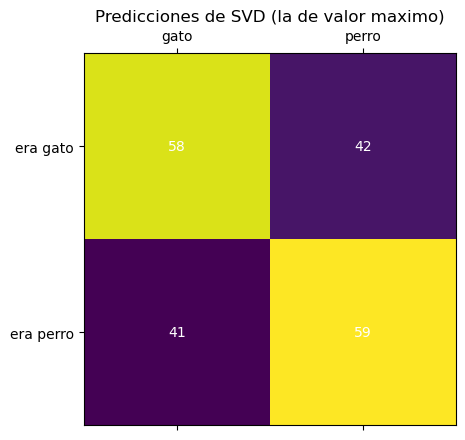

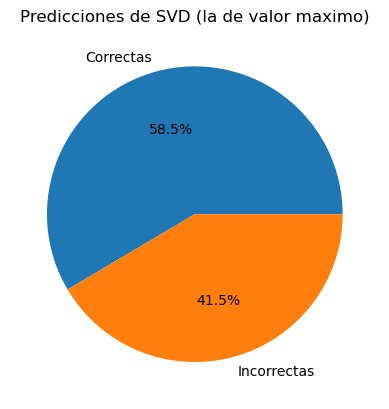

In [51]:
graficar_predicciones_de_metodo("SVD", YvEsperadosSVD, Yv)

### Cholesky / Ecuaciones Normales

In [52]:
tiempo = datetime.now()

LCholesky = cache(lambda: cholesky(matmul(Xt, traspuesta(Xt))), "LCholesky")

WEqNorm = cache(lambda:pinvEcuacionesNormales(Xt,LCholesky,Yt), "WEN")

YvEsperadosEqNorm = cache(lambda:matmul(WEqNorm, Xv), "YvEsperadosEqNorm")



choleskizando 0-esima columna a las 12:56:29.655503
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [53]:
print("Tardo:", (datetime.now()-tiempo).seconds, "segundos")

Tardo: 0 segundos


In [54]:

print(f"W: {np.round(WEqNorm,3).shape}")
pseudoAssertEquality(LCholesky @ traspuesta(LCholesky), matmul(Xt, traspuesta(Xt)), atol=tol)

print(YvEsperadosEqNorm)
print(Yv)


LCholeskyNP = np.linalg.cholesky(Xt @ Xt.T)

WWEqNormNP = pinvEcuacionesNormales(Xt, LCholeskyNP, Yt)
YvEsperadosEqNormNP = WWEqNormNP @ Xv
# es tan inestable que este assert puede fallar!
# assert np.allclose(YvEsperadosEqNormNP, YvEsperadosEqNorm, atol=0.01)


W: (2, 100)
[[ 0.403 -0.173  0.172  0.977  0.011  0.317  0.913  1.095 -0.328  0.269  0.658  0.519  0.924  0.505  1.024  0.472  1.807  0.107  1.208  0.31  -0.22
   0.326 -0.059  0.807  1.276 -0.133  0.444  0.607  0.426  0.044  0.419 -0.038  0.671  0.599  0.092  0.017  0.15  -0.656  0.983 -0.295  0.509  0.712
  -0.011 -0.09   0.994  0.637  0.18   0.639  0.137  0.202  0.608  0.306  0.19   0.711 -0.27  -0.511  1.254 -0.483  0.47   0.223  1.039  1.114 -0.613
   0.618  0.434  0.86  -0.124  0.547 -0.106  0.116  0.771  0.35   0.404  0.315  0.436  2.349 -0.061 -0.52   0.681  0.568 -0.115  0.394  0.166 -0.065
  -0.392  0.721  0.348  1.408  0.045  0.704  0.636  0.385  0.505  0.02   0.623  1.178 -0.137 -0.005  0.131  0.18   0.509  1.28   0.855  0.287  1.131
  -0.012  0.144  0.211  1.094 -0.23   0.344 -0.191  0.351 -0.466  1.239  1.061 -0.257  0.85   0.55   1.63  -0.071  0.44   0.783  0.538  0.92   0.548
   0.063 -0.201  0.074  0.58   0.765  0.263  0.885  1.378  1.161  0.935 -0.324 -0.163  0.44   0

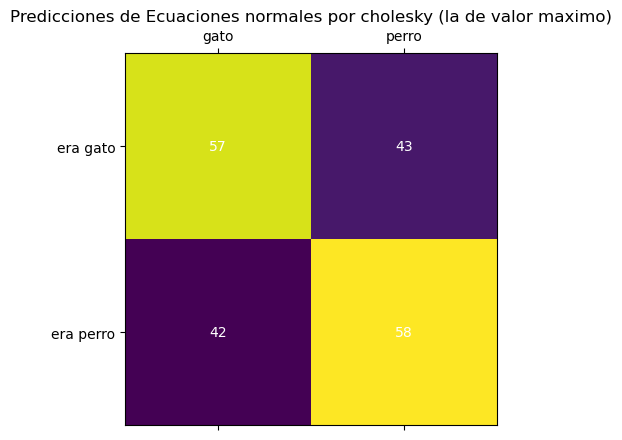

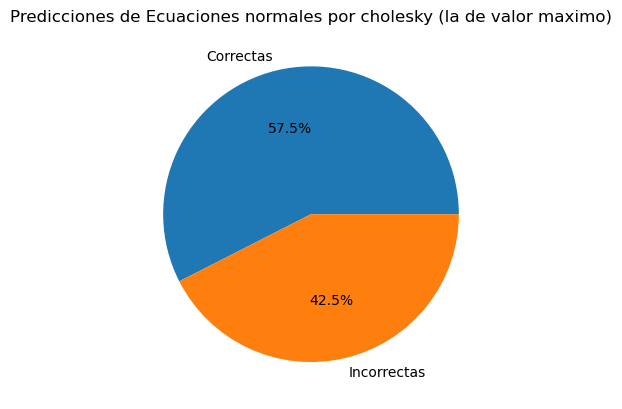

In [55]:
graficar_predicciones_de_metodo("Ecuaciones normales por cholesky", YvEsperadosEqNorm, Yv)